# Implementacion de un modelo de Deep Learning
### Marcela Ibarra Mora A01231973

In [13]:
# importar librerias
import os,  shutil
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

In [3]:
# Importar data set con datos de los artistias
artist = pd.read_csv('/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/artists.csv')
artist.head(3)

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70

In [3]:
#Sacar 4 los artistas con mayor numero de pinturas 
top = artist.nlargest(4,'paintings')
top = top[['name','paintings']].reset_index(drop=True)

#Se juntan las categorias de Pablo Picasso y Pierre Auguste para sea más facil para el modelo
top.loc[2] += top.loc[3]
top.drop([3], inplace=True)

#Se quitan los espacios de los nombres
top_name = top['name'].str.replace(' ', '_').values
top['name'] = top['name'].str.replace(' ', '_').values
top['paintings'] = top['paintings'].replace([775], 438)
top

name  paintings
0                    Vincent_van_Gogh        877
1                         Edgar_Degas        702
2  Pablo_PicassoPierre-Auguste_Renoir        438

In [ ]:
top_name

array(['Vincent_van_Gogh', 'Edgar_Degas',
       'Pablo_PicassoPierre-Auguste_Renoir'], dtype=object)

In [4]:
# Directorio original con las imagenes
dir = '/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/images'
# Se crea un directorio nuevo para las imagenes que se utilizaran para el modelo
base_dir = '/content/drive/MyDrive/7 SEMESTRE/BLOQUE 2/DEEP_LEARNING/Entrega/prueba'

Divide Dataset in train, validation and test

In [5]:
# directorios de train validation y test
dir_train = os.path.join(base_dir,'train')
dir_val = os.path.join(base_dir,'val')
dir_test = os.path.join(base_dir,'test')

In [ ]:
# Copiar imagenes a los directorios
def split_dataset(top_name):
  # Inside of each train, val and test directories, one more for each artist
  for i in range(len(top_name)):
    os.mkdir(os.path.join(dir_train,top_name[i]))
    os.mkdir(os.path.join(dir_val,top_name[i]))
    os.mkdir(os.path.join(dir_test,top_name[i]))

  for i in range(len(top_name)):
    num = top[top['name']==top_name[i]].paintings
    to_train = math.floor(num*0.64)
    to_val = math.floor(num*0.15)
    to_test = math.floor(num*0.20)
    
    fnames = ['{name}_{num}.jpg'.format(name = top_name[i], num = j) for j in range (1,to_train)]
    for fname in fnames:
      src = os.path.join(os.path.join(dir,top_name[i]),fname)
      dst = os.path.join(os.path.join(dir_train,top_name[i]), fname)
      shutil.copyfile(src,dst)
      
    fnames = ['{name}_{num}.jpg'.format(name = top_name[i], num = j) for j in range (to_train, (to_train+to_val))]
    for fname in fnames:
      src = os.path.join(os.path.join(dir,top_name[i]),fname)
      dst = os.path.join(os.path.join(dir_val,top_name[i]), fname)
      shutil.copyfile(src,dst)
      
    fnames = ['{name}_{num}.jpg'.format(name = top_name[i], num = j) for j in range ((to_train+to_val),(to_train+to_val+to_test))]
    for fname in fnames:
      src = os.path.join(os.path.join(dir,top_name[i]),fname)
      dst = os.path.join(os.path.join(dir_test,top_name[i]), fname)
      shutil.copyfile(src,dst)

In [ ]:
# Separar imagenes
split_dataset(top_name)

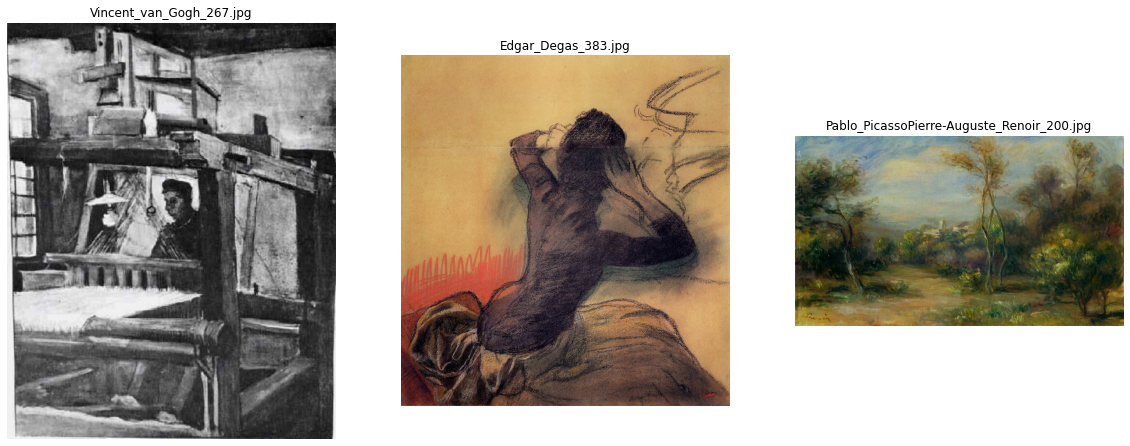

In [ ]:
# Mostar algunas imagenes
fig, axes = plt.subplots(1, 3,figsize = (20,10))

import random
for i in range(3):
  artist_toshow = top_name[i] #artist_show[i]
  choice = random.choice(os.listdir(os.path.join(dir, artist_toshow)))
  image_file = os.path.join(dir,artist_toshow, choice)
  image = plt.imread(image_file)
  axes[i].imshow(image)
  axes[i].set_title(choice)
  axes[i].axis('off')

Class weights

In [ ]:
# Algunos artistas tienes mas imagenes que otros, 
# por lo que se van a usar pesos durante el entrenamiento
top['class_weight'] = top.paintings.sum() / (top.shape[0] * top.paintings)
top = top.set_index('name')
class_weights = top['class_weight'].reset_index()
class_weights = class_weights['class_weight'].to_dict()
class_weights

{0: 0.7666286583048271, 1: 0.9577397910731245, 2: 1.535007610350076}

Data Augmentation

In [ ]:
artist_name = top.index.to_list()
artist_name

['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_PicassoPierre-Auguste_Renoir']

In [ ]:
# Tranformations
train_datagen = ImageDataGenerator(
							#rescale = 1./255,
							#rotation_range = 40,
							#width_shift_range = 0.2,
							#height_shift_range = 0.2,
							#shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,)

val_datagen = ImageDataGenerator(1./255)

train_generator = train_datagen.flow_from_directory(
							dir_train,
							class_mode='categorical',
							target_size = (224, 224),
							batch_size = 20,
							shuffle = True,
							classes = artist_name)

val_generator = val_datagen.flow_from_directory(
							dir_val,
							class_mode='categorical',
							target_size = (224,224),
							batch_size =20,
							classes= artist_name)


Found 1287 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


(-0.5, 1023.5, 609.5, -0.5)

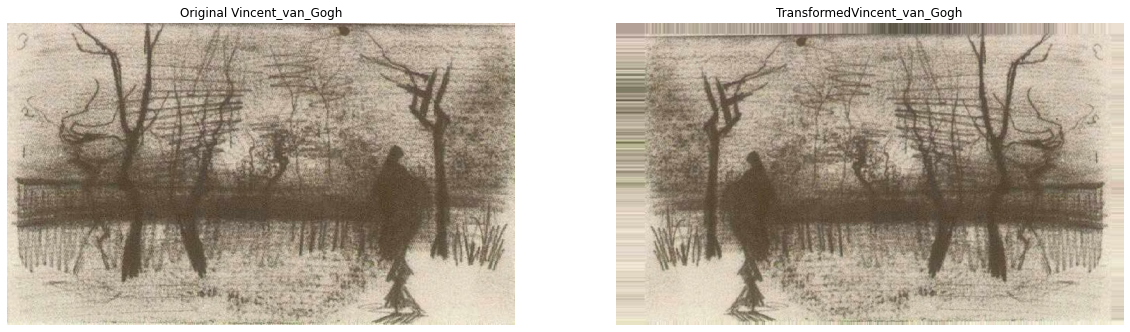

In [ ]:
# Print some exameples for the transformations
fig, axes = plt.subplots(1, 2, figsize=(20,10))

name_artist = 'Vincent_van_Gogh'
choice = random.choice(os.listdir(os.path.join(dir, name_artist)))
image_file = os.path.join(dir,name_artist, choice)

image = plt.imread(image_file)
axes[0].imshow(image)
axes[0].set_title("Original " + name_artist)
axes[0].axis('off')

trans_image = train_datagen.random_transform(image)
axes[1].imshow(trans_image)
axes[1].set_title("Transformed" + name_artist)
axes[1].axis('off')

Model

In [ ]:
# Using transferlearning with the model ResNet50 with the imagenet weights
base = ResNet50(weights='imagenet', 
                include_top=False, 
                input_shape=(224,224,3))

# Indicating that the basemodel will be "frozen"
base.trainable = False

# Create model
model = models.Sequential()
# add the base
model.add(base)
# add a flatten layer
model.add(layers.Flatten())
# add a dense layer
#model.add(layers.Dense(256,activation='relu'))
# add the clasification layer
model.add(layers.Dense(3,activation='softmax'))

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# compile model, with categorical_crossentropy as a loss function and Adam as a optimizer
model.compile(loss='categorical_crossentropy',
						optimizer=optimizers.Adam(lr=0.0001),
						metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

# Train the model
history = model.fit(train_generator, 
				steps_per_epoch = STEP_SIZE_TRAIN,  
				epochs =10, 
				validation_data= val_generator, 
				validation_steps = STEP_SIZE_VALID,
        class_weight = class_weights)

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 1.5576 - acc: 0.6304

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


72/72 [==============================] - 361s 5s/step - loss: 1.5576 - acc: 0.6304 - val_loss: 0.6474 - val_acc: 0.8167
Epoch 2/10
72/72 [==============================] - 328s 5s/step - loss: 0.6118 - acc: 0.8170 - val_loss: 0.5685 - val_acc: 0.8567
Epoch 3/10
72/72 [==============================] - 331s 5s/step - loss: 0.4897 - acc: 0.8548 - val_loss: 0.7124 - val_acc: 0.8467
Epoch 4/10
72/72 [==============================] - 325s 5s/step - loss: 0.2882 - acc: 0.9060 - val_loss: 0.6201 - val_acc: 0.8533
Epoch 5/10
72/72 [==============================] - 323s 4s/step - loss: 0.2537 - acc: 0.9180 - val_loss: 0.4125 - val_acc: 0.9133
Epoch 6/10
72/72 [==============================] - 324s 4s/step - loss: 0.1836 - acc: 0.9418 - val_loss: 0.3601 - val_acc: 0.9067
Epoch 7/10
72/72 [==============================] - 322s 4s/step - loss: 0.1667 - acc: 0.9446 - val_loss: 0.4652 - val_acc: 0.8867
Epoch 8/10
72/72 [==============================] - 322s 4s/step - loss: 0.1227 - acc: 0.9628 

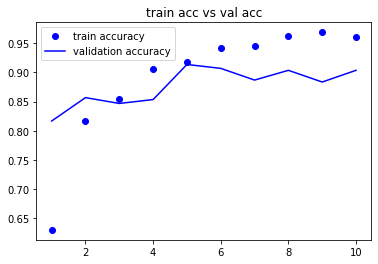

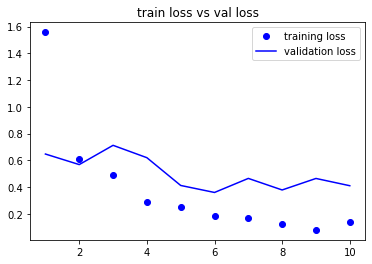

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

un poco de overfiting...

otro modelo pero con una capa densa más

In [ ]:
# Create model
model1 = models.Sequential()
# add the base
model1.add(base)
# add a flatten layer
model1.add(layers.Flatten())
# add a dense layer
model1.add(layers.Dense(256,activation='relu'))
# add a dense layer
#model1.add(layers.Dense(64,activation='relu'))
# add a dropout layer
#model1.add(layers.Dropout(0.5))
# add the clasification layer
model1.add(layers.Dense(3,activation='softmax'))

model1.summary()

# compile model, with categorical_crossentropy as a loss function and Adam as a optimizer
model1.compile(loss='categorical_crossentropy',
						optimizer=optimizers.Adam(lr=0.0001),
						metrics=['acc'])

# Train the model
history = model1.fit(train_generator, 
				steps_per_epoch = STEP_SIZE_TRAIN,  
				epochs =10, 
				shuffle = True,
				validation_data= val_generator, 
				validation_steps = STEP_SIZE_VALID,
        class_weight = class_weights)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               25690368  
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 49,278,851
Trainable params: 25,691,139
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
72/72 [==============================] - 339s 5s/step - loss: 1.6257 - acc: 0.6339 - val_loss: 0.5223 - val_acc: 0.8133
Epoch 2/10
72/72 [================

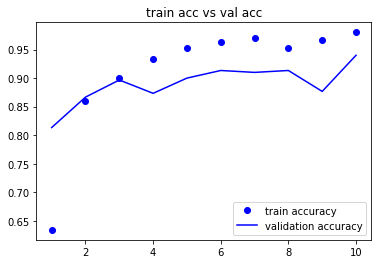

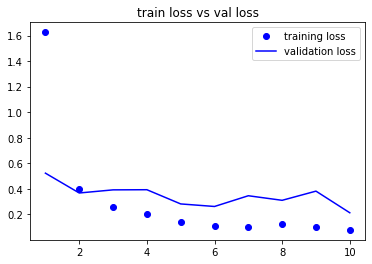

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Agregar otra categoria

In [6]:
top = artist.nlargest(6,'paintings')
top = top[['name','paintings']].reset_index(drop=True)

# Se juntas las categorias de Albertcht Dürer y Paul Gauguin
top.loc[2] += top.loc[3]
top.loc[4] += top.loc[5]
top.drop([3], inplace=True)
top.drop([5], inplace=True)

#Se quitan los espacios de los nombres
top['name'] = top['name'].str.replace(' ', '_').values
top['name'] = top['name'].str.replace('Albrecht_DürerPaul_Gauguin', 'Albrecht_DurerPaul_Gauguin').values
top_name = top['name'].str.replace(' ', '_').values
top['paintings'] = top['paintings'].replace([775], 438)
top['paintings'] = top['paintings'].replace([639], 327)
top

name  paintings
0                    Vincent_van_Gogh        877
1                         Edgar_Degas        702
2  Pablo_PicassoPierre-Auguste_Renoir        438
4          Albrecht_DurerPaul_Gauguin        327

In [ ]:
split_dataset(top_name)

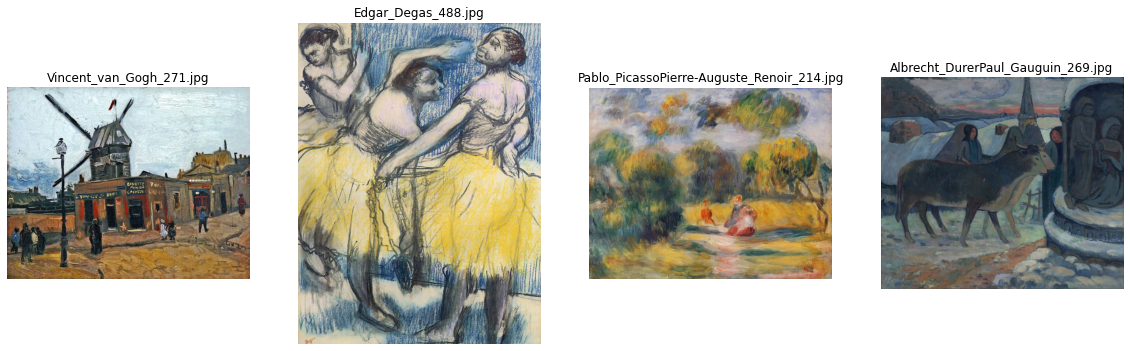

In [ ]:
#Print some pantings
#artist_show = ['Vincent_van_Gogh','Frida_Kahlo','Andy_Warhol','Claude_Monet','Leonardo_da_Vinci','Diego_Rivera']
fig, axes = plt.subplots(1, 4,figsize = (20,10))

import random
for i in range(4):
  artist_toshow = top_name[i] #artist_show[i]
  choice = random.choice(os.listdir(os.path.join(dir, artist_toshow)))
  image_file = os.path.join(dir,artist_toshow, choice)
  image = plt.imread(image_file)
  axes[i].imshow(image)
  axes[i].set_title(choice)
  axes[i].axis('off')

In [7]:
artist_name = top['name'].to_list()
artist_name

['Vincent_van_Gogh',
 'Edgar_Degas',
 'Pablo_PicassoPierre-Auguste_Renoir',
 'Albrecht_DurerPaul_Gauguin']

In [8]:
# Tranformations
train_datagen = ImageDataGenerator(
							#rescale = 1./255,
							#rotation_range = 40,
							#width_shift_range = 0.2,
							#height_shift_range = 0.2,
							#shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,)

val_datagen = ImageDataGenerator(1./255)

train_generator = train_datagen.flow_from_directory(
							dir_train,
							class_mode='categorical',
							target_size = (224, 224),
							batch_size = 20,
							shuffle = True,
							classes = artist_name)

val_generator = val_datagen.flow_from_directory(
							dir_val,
							class_mode='categorical',
							target_size = (224,224),
							batch_size =20,
							classes= artist_name)

Found 1495 images belonging to 4 classes.
Found 350 images belonging to 4 classes.


(-0.5, 1399.5, 1316.5, -0.5)

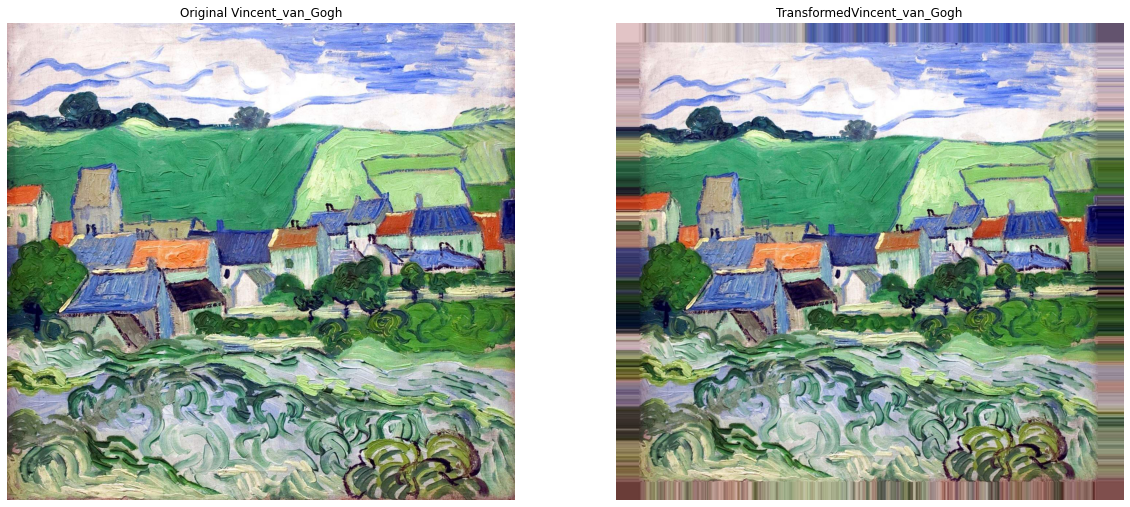

In [ ]:
# Print some exameples for the transformations
fig, axes = plt.subplots(1, 2, figsize=(20,10))

name_artist = 'Vincent_van_Gogh'
choice = random.choice(os.listdir(os.path.join(dir, name_artist)))
image_file = os.path.join(dir,name_artist, choice)

image = plt.imread(image_file)
axes[0].imshow(image)
axes[0].set_title("Original " + name_artist)
axes[0].axis('off')

trans_image = train_datagen.random_transform(image)
axes[1].imshow(trans_image)
axes[1].set_title("Transformed" + name_artist)
axes[1].axis('off')

In [9]:
# Algunos artistas tienes mas imagenes que otros, 
# por lo que se van a usar pesos durante el entrenamiento
top['class_weight'] = top.paintings.sum() / (top.shape[0] * top.paintings)
top = top.set_index('name')
class_weights = top['class_weight'].reset_index()
class_weights = class_weights['class_weight'].to_dict()
class_weights

{0: 0.6681870011402509,
 1: 0.8347578347578347,
 2: 1.3378995433789955,
 3: 1.7920489296636086}

In [ ]:
# Using transferlearning with the model ResNet50 with the imagenet weights
base = ResNet50(weights='imagenet', 
                include_top=False, 
                input_shape=(224,224,3))

# Indicating that the basemodel will be "frozen"
base.trainable = False

# Create model
model2 = models.Sequential()
# add the base
model2.add(base)
# add a flatten layer
model2.add(layers.Flatten())
# add a dense layer
model2.add(layers.Dense(256,activation='relu'))
# add a dense layer
#model1.add(layers.Dense(64,activation='relu'))
# add a dropout layer
#model1.add(layers.Dropout(0.5))
# add the clasification layer
model2.add(layers.Dense(4,activation='softmax'))

model2.summary()

# compile model, with categorical_crossentropy as a loss function and Adam as a optimizer
model2.compile(loss='categorical_crossentropy',
						optimizer=optimizers.Adam(lr=0.0001),
						metrics=['acc'])

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

# Train the model
history = model2.fit(train_generator, 
				steps_per_epoch = STEP_SIZE_TRAIN,  
				epochs =10, 
				shuffle = True,
				validation_data= val_generator, 
				validation_steps = STEP_SIZE_VALID,
        class_weight = class_weights)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
74/74 [==============================] - ETA: 0s - loss: 1.5108 - acc: 0.6271

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


74/74 [==============================] - 338s 5s/step - loss: 1.5108 - acc: 0.6271 - val_loss: 0.7852 - val_acc: 0.7912
Epoch 2/10
74/74 [==============================] - 336s 5s/step - loss: 0.3675 - acc: 0.8685 - val_loss: 0.7479 - val_acc: 0.7941
Epoch 3/10
74/74 [==============================] - 343s 5s/step - loss: 0.2451 - acc: 0.8990 - val_loss: 0.6935 - val_acc: 0.8382
Epoch 4/10
74/74 [==============================] - 353s 5s/step - loss: 0.2127 - acc: 0.9297 - val_loss: 0.9548 - val_acc: 0.8088
Epoch 5/10
74/74 [==============================] - 370s 5s/step - loss: 0.1684 - acc: 0.9397 - val_loss: 0.8512 - val_acc: 0.8294
Epoch 6/10
74/74 [==============================] - 361s 5s/step - loss: 0.1623 - acc: 0.9363 - val_loss: 1.0623 - val_acc: 0.8176
Epoch 7/10
74/74 [==============================] - 361s 5s/step - loss: 0.2033 - acc: 0.9254 - val_loss: 0.9252 - val_acc: 0.8353
Epoch 8/10
74/74 [==============================] - 348s 5s/step - loss: 0.0776 - acc: 0.9708 

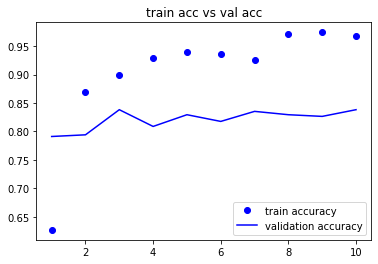

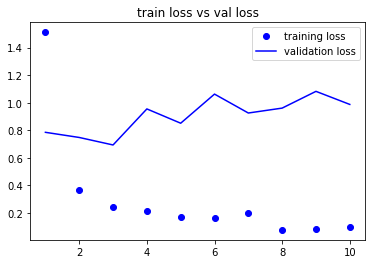

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [10]:
# Using transferlearning with the model ResNet50 with the imagenet weights
base = ResNet50(weights='imagenet', 
                include_top=False, 
                input_shape=(224,224,3))

# Indicating that the basemodel will be "frozen"
base.trainable = False

# Create model
model3 = models.Sequential()
# add the base
model3.add(base)
# add a flatten layer
model3.add(layers.Flatten())
# add a dense layer
model3.add(layers.Dense(256,activation='relu'))
# add a dropout layer
model3.add(layers.Dropout(0.5))
# add the clasification layer
model3.add(layers.Dense(4,activation='softmax'))

model3.summary()

# compile model, with categorical_crossentropy as a loss function and Adam as a optimizer
model3.compile(loss='categorical_crossentropy',
						optimizer=optimizers.Adam(lr=0.0001),
						metrics=['acc'])

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

# Train the model
history = model3.fit(train_generator, 
				steps_per_epoch = STEP_SIZE_TRAIN,  
				epochs =15, 
				shuffle = True,
				validation_data= val_generator, 
				validation_steps = STEP_SIZE_VALID,
        class_weight = class_weights)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
____________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
74/74 [==============================] - ETA: 0s - loss: 1.9819 - acc: 0.5349

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


74/74 [==============================] - 379s 5s/step - loss: 1.9819 - acc: 0.5349 - val_loss: 0.6563 - val_acc: 0.7618
Epoch 2/15
74/74 [==============================] - 47s 639ms/step - loss: 0.7220 - acc: 0.7281 - val_loss: 0.5737 - val_acc: 0.7941
Epoch 3/15
74/74 [==============================] - 48s 643ms/step - loss: 0.5878 - acc: 0.7803 - val_loss: 0.5942 - val_acc: 0.8059
Epoch 4/15
74/74 [==============================] - 48s 644ms/step - loss: 0.4666 - acc: 0.8319 - val_loss: 0.6150 - val_acc: 0.8147
Epoch 5/15
74/74 [==============================] - 47s 642ms/step - loss: 0.4685 - acc: 0.8298 - val_loss: 0.7258 - val_acc: 0.8118
Epoch 6/15
74/74 [==============================] - 48s 647ms/step - loss: 0.3668 - acc: 0.8651 - val_loss: 0.5334 - val_acc: 0.8559
Epoch 7/15
74/74 [==============================] - 48s 650ms/step - loss: 0.3446 - acc: 0.8739 - val_loss: 0.5641 - val_acc: 0.8382
Epoch 8/15
74/74 [==============================] - 48s 644ms/step - loss: 0.3216 

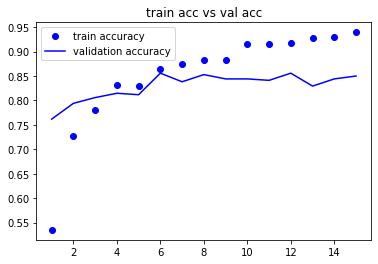

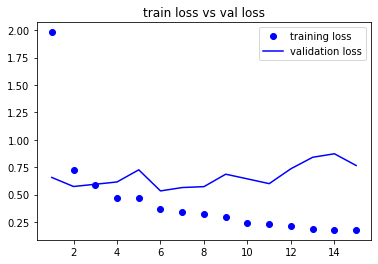

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Evaluate model

In [12]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
							dir_test,
							class_mode='categorical',
							target_size = (224, 224),
							batch_size = 20,
							shuffle = True,
							classes = artist_name)
test_loss, test_acc = model3.evaluate(test_generator)
print('\ntest acc :\n', test_acc)

Found 467 images belonging to 4 classes.
24/24 [==============================] - 72s 3s/step - loss: 2.0796 - acc: 0.7066

test acc :
 0.7066380977630615


El modelo todavia presenta señales de overfitting, esto puede ser devido a que no se cuenta con la misma cantidad de imagenes para cada una de las clases, por otro lado, se podria seguir intentado cambiar los hiper parametros como el learning rate. Agregar un batch normalization, entre otras tecnicas. Pero por otro lado, al momento de intentar estas tecnicas, no tuvieron mucho exito, ya que el accuracy de validacion no pasaba del 83%. 

1/1 [==============================] - 0s 21ms/step


(-0.5, 1561.5, 2047.5, -0.5)

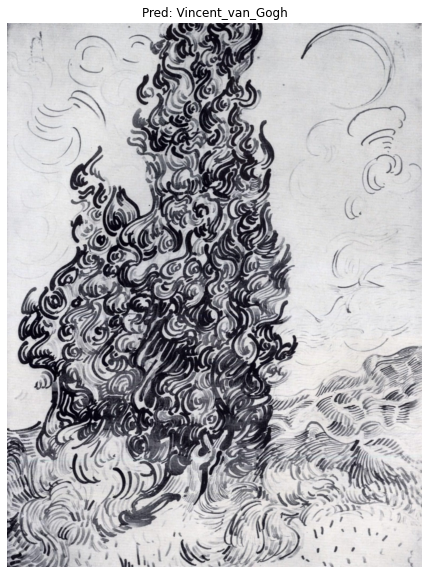

In [24]:
import random
name_artist = 'Vincent_van_Gogh'
choice = random.choice(os.listdir(os.path.join(dir, name_artist)))
image_file = os.path.join(dir,name_artist, choice)

img =  tf.keras.utils.load_img(image_file,target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array /= 255.


pred = model3.predict(img_array)
score = tf.nn.softmax(pred)
answer1 = np.argmax(pred)

if answer1 == 0:
  artist = 'Vincent_van_Gogh'
else:
  artist = 'not found'

fig, axes = plt.subplots(1, 1, figsize=(20,10))

image = plt.imread(image_file)
axes.imshow(image)
axes.set_title("Pred: " + artist)
axes.axis('off')

Es claro que este problema es muy complicado debido a que se busca que la red aprenda estilos y tecturas de cada uno de los artistas, por lo que el uso de otra red base podria ayudar al desepeño del accuracy.